# Analysis of the Haldane and Kane-Mele models in the context of the topological properties of twisted MoTe₂/WSe₂ bilayer (Haldane graphene model).

The main aim of this script is to create computational model of Haldane Chern insulator. The Chern insulator exhibits a quantized Hall effect without Landau levels. Theoretically, this state can be achieved by designing complex next-nearest-neighbour hopping on a honeycomb lattice, known as the Haldane model.

Python program located below was created based on theory presented in work: https://topocondmat.org/w4_haldane/haldane_model.html. It is a basic Haldane model using graphene as an example.

This research was funded by the National Science Centre Poland (NCN) according to decision 2021/42/E/ST3/00128

In [3]:
from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import kwant

import scipy.linalg as la
from math import atan2, pi, sqrt, exp

import scipy
import tinyarray
from IPython.display import display, Math

The primitive translation vectors of the honeycomb lattice are defined as follows: 

\begin{equation*}
    \mathbf{a} = [1,0],  \hspace{3mm} \mathbf{b} = [\frac{1}{2}, \frac{\sqrt{3}}{2}],
\end{equation*}
together with a vector connecting A and B sites equal to $\mathbf{c} = [0 , \frac{1}{\sqrt{3}}]$.  

In [4]:
#The fundamental translation vectors
a = np.array([1, 0])
b = np.array([1/2, np.sqrt(3)/2])

#Vector from A to B site
c = np.array([0, 1/(np.sqrt(3))])

#Vectors AB
delta_AB_1 = c 
delta_AB_2 = c - b
delta_AB_3 = a - b + c 
deltas_AB = [delta_AB_1, delta_AB_2, delta_AB_3]

#Vectors BA
delta_BA_1 = (-1)*c 
delta_BA_2 = b-c
delta_BA_3 = (-1)*(a - b + c)
deltas_BA = [delta_BA_1, delta_BA_2, delta_BA_3]

#Vectors AA 
delta_AA_1 = (-1)*a
delta_AA_2 = b 
delta_AA_3 = a-b 
delta_AA_4 = a 
delta_AA_5 = (-1)*b  
delta_AA_6 = np.array([-0.5, np.sqrt(3)/(2)]) 
deltas_AA = [delta_AA_1, delta_AA_2, delta_AA_3, delta_AA_4, delta_AA_5, delta_AA_6]

#Vectors BB
delta_BB_1 = (-1)*a
delta_BB_2 = b
delta_BB_3 = a-b 
delta_BB_4 = a 
delta_BB_5 = (-1)*b
delta_BB_6 = b-a 
deltas_BB = [delta_BB_1, delta_BB_2, delta_BB_3, delta_BB_4, delta_BB_5, delta_BB_6]

Here, we create function $f_k$ that calculates sum of exponents in the form of  $\sum_{j} e^{i \mathbf{k} \cdot \mathbf{a}_j}$ multiplied by the hopping term. $\mathbf{a}_j$ are the vectors connecting nearest and next-nearest-neighbours. 

In [5]:
#range of k
N=100
kx = np.linspace(-4*np.pi/(3), 4*np.pi/(3), N)
ky = np.linspace(-8*np.pi/(7), 8*np.pi/(7), N)

#function that calculates e_k
def f_k(deltas_table, t_table, kx, ky):
    sum_f = 0
    for i in range(len(deltas_table)):
        sum_f += t_table[i] * np.exp(1j * (kx * deltas_table[i][0] + ky * deltas_table[i][1]))
    return sum_f

The following tight-binding Hamiltonian was adopted:

\begin{equation}
H_\alpha = \sum_{\langle \langle i,j \rangle \rangle,\alpha} \left( t_\alpha \tau_{\alpha} v_{i,j} a_{i}^\dagger a_{j}   \right) 
 + \sum_{i \in \alpha} \left( \tau_{\alpha} M n_i \right), \hspace{4mm}
H_{AB} = - t_{AB} \sum_{\langle i,j \rangle} \left( a_{i}^\dagger a_j \right),
\end{equation}

where: 

$\alpha = A,B$ denotes the two sublattices with $\tau_A = - \tau_B$ = 1,  

$v_{i,j} = \pm 1$ denotes the two opposite hopping directions (+1 for clokwise, -1 for anticlockwise), 

$t_A, t_B, t_{AB}$ denote hopping amplitudes, 

$M$ is the onsite energy. 

It should be emphasized that next-nearest-neighbour hoppings change sign depending on the direction due to $v_{i,j}$ ($v_{i,j} = 1$ for clockwise path and $v_{i,j} = -1$ for anticlockwise path). Furthermore, hoppings AA have opposite signs to BB due to $\tau_{\alpha}$. The class "Hamiltonian" contains arrays v_AB, v_BA, v_AA and v_BB which take that into account.

Above Hamiltonian can be transformed into momentum space using Fourier transform and
presented in matrix form. In the method "problem_wlasny" we solve an eigen problem of the matrix: 

\begin{equation}
H(\mathbf{k}) = 
\begin{pmatrix}
f_{AA}(\mathbf{k}) + M & f_{AB}(\mathbf{k}) \\
f_{BA}(\mathbf{k}) & f_{BB}(\mathbf{k}) - M
\end{pmatrix},
\end{equation}

where 

$f_{A, A}(\mathbf{k}) =  \sum_{\langle \langle i,j \rangle \rangle} t_{AA} v_{i,j} e^{i \mathbf{k} \cdot \mathbf{\delta}_{i,j}}$, 

$f_{B, B}(\mathbf{k}) =  - \sum_{\langle \langle i,j \rangle \rangle} t_{BB} v_{i,j} e^{i \mathbf{k} \cdot \mathbf{\delta}_{i,j}}$, 

$f_{A, B}(\mathbf{k}) = \sum_{\langle i,j \rangle} t_{A} e^{i \mathbf{k} \cdot \mathbf{\Delta}_{i,j}}$, 

$f_{B, A}(\mathbf{k}) = \sum_{\langle i,j \rangle} t_{B} e^{i \mathbf{k} \cdot \mathbf{\Delta}_{i,j}}$. 

$\mathbf{\Delta}_{i,j}$ and $\mathbf{\delta}_{i,j}$  are the vectors connecting nearest and next-nearest-neighbours (defined in the cell two above). $f_{\alpha, \alpha^{\prime}}(\mathbf{k})$ is calculated with function $f_k$ that is defined in one cell above. The onsite energy has been taken as $M = 0.2$, and hopping amplitude $t_{AB}$ as 1. Next-nearest-neighbour hopping amplitudes are equal for both sublattices ($t_A$ = $t_B$). 

Every result and chart presented below was created based on this parameter definition.  It should be noted that this Python script allow for easy adjustment of these values. Especially hopping amplitudes ($t_A$ = $t_B$) should be manipulated in order to see when the material becomes the Chern insulator.


In [6]:
#Definition of the calss that contains onsite energy, hopping arrays and primitive translation vectors arrays 
class Hamiltonian:
    def __init__(self, onsite, t_AB, t_BA, t_AA, t_BB, deltas_AB_table, deltas_BA_table, deltas_AA_table, deltas_BB_table):
        self.onsite = onsite
        #Tables of hopping signs
        self.v_AB = np.array([1, 1 ,1])
        self.v_BA = np.array([1, 1, 1])
        self.v_AA = np.array([1, 1, 1, -1, -1, -1])
        self.v_BB = np.array([1, 1, 1, -1, -1, -1])*(-1)
        #Tables of hoppings
        self.t_AB_table = t_AB*self.v_AB
        self.t_BA_table = t_BA*self.v_BA
        self.t_AA_table = t_AA*self.v_AA
        self.t_BB_table = t_BB*self.v_BB
        self.deltas_AB_table = deltas_AB_table
        self.deltas_BA_table = deltas_BA_table
        self.deltas_AA_table = deltas_AA_table
        self.deltas_BB_table = deltas_BB_table
#Method that solves an eigen problem
    def problem_wlasny(self, kx, ky):
            Matrix = np.zeros((2,2), dtype = complex)
            Matrix[0][1] = f_k(self.deltas_AB_table, self.t_AB_table, kx, ky)
            Matrix[1][0] = f_k(self.deltas_BA_table, self.t_BA_table, kx, ky)
            Matrix[0][0] = self.onsite + f_k(self.deltas_AA_table, self.t_AA_table, kx, ky)
            Matrix[1][1] = -self.onsite + f_k(self.deltas_BB_table, self.t_BB_table, kx, ky)
            ene, v = np.linalg.eigh(Matrix) 
            return ene, v 

Here, we only draw function $f_k$ to see, if everything works fine.

Onsite energy = 0.2
t_aa = -0.03849001794597505j


Text(0.5, 1.0, 'BB')

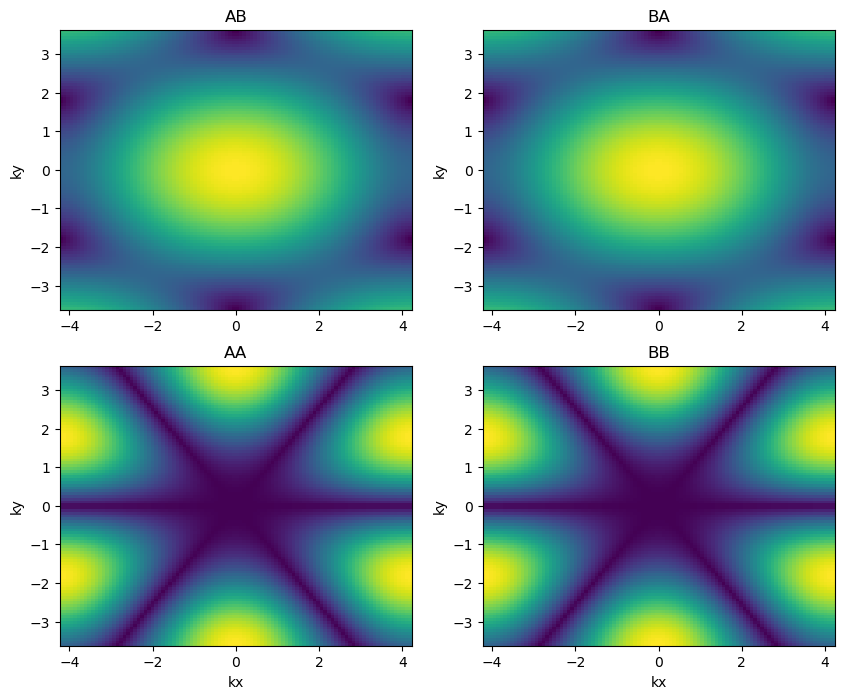

In [7]:
#Drawing f_k function
Onsite = 0.2
t_aa = -1j*Onsite/(3*np.sqrt(3))
t_bb = -1j*Onsite/(3*np.sqrt(3))
t_AB = np.array([1, 1 ,1])
t_BA = np.array([1, 1, 1])
t_AA = np.array([1, 1, 1, -1, -1, -1])*t_aa
t_BB = np.array([-1, -1, -1, 1, 1, 1])*t_bb

Kx, Ky = np.meshgrid(kx,ky)
e_AB_values = np.zeros((N,N), dtype = complex)
e_BA_values = np.zeros((N,N), dtype = complex)
e_AA_values = np.zeros((N,N), dtype = complex)
e_BB_values = np.zeros((N,N), dtype = complex)
for i in range(N):
    for j in range(N):
        e_AB_values[i][j] = f_k(deltas_AB, t_AB, kx[i],ky[j]) 
        e_BA_values[i][j] = f_k(deltas_BA, t_BA, kx[i],ky[j]) 
        e_AA_values[i][j] = f_k(deltas_AA, t_AA, kx[i],ky[j]) 
        e_BB_values[i][j] = f_k(deltas_BB, t_BB, kx[i],ky[j]) 

print(f"Onsite energy = {Onsite}")
print(f"t_aa = {t_aa}")
    
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
axs[0, 0].pcolor(Kx, Ky, abs(e_AB_values),  shading='auto' )
#axs[0, 0].set_xlabel("kx")
axs[0, 0].set_ylabel("ky")
axs[0, 0].set_title("AB")
    
axs[0, 1].pcolor(Kx, Ky, abs(e_BA_values),  shading='auto' )
#axs[0, 1].set_xlabel("kx")
axs[0, 1].set_ylabel("ky")
axs[0, 1].set_title("BA")
    
axs[1, 0].pcolor(Kx, Ky, abs(e_AA_values),  shading='auto' )
axs[1, 0].set_xlabel("kx")
axs[1, 0].set_ylabel("ky")
axs[1, 0].set_title("AA")
    
axs[1, 1].pcolor(Kx, Ky, abs(e_BB_values),  shading='auto' )
axs[1, 1].set_xlabel("kx")
axs[1, 1].set_ylabel("ky")
axs[1, 1].set_title("BB")

# plt.pcolor(Kx, Ky, abs(e_AB_values),  shading='auto' )
# plt.xlabel("kx")
# plt.ylabel("ky")
# plt.colorbar()
# plt.title(r"$|f_{A,B}(\mathbf{k})| = |f_{B,A}(\mathbf{k})|$")
# plt.savefig('f_k_1.jpg', dpi = 300, bbox_inches='tight')
# plt.show

# plt.pcolor(Kx, Ky, abs(e_AA_values),  shading='auto' )
# plt.xlabel("kx")
# plt.ylabel("ky")
# plt.title(r"$|f_{A}(\mathbf{k})| = |f_{B}(\mathbf{k})|$")
# plt.savefig('f_k_2.jpg', dpi = 300, bbox_inches='tight')
# plt.show

Now, we calculate the bandstructure:

In [8]:
def plot_wf(p=0):
    #onsite energy
    Onsite = 0.2

    #Hopping energies
    t_AA = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_BB = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_AB = 1
    t_BA = 1
    k_matrix_plus = np.zeros((N,N))
    k_matrix_minus = np.zeros((N,N))
    
    #Hamiltonian Matrix
    for i in range(N):
        for j in range(N):
            hamiltonian = Hamiltonian(Onsite, t_AB, t_BA, t_AA, t_BB, deltas_AB, deltas_BA, deltas_AA, deltas_BB)
            ene, v = hamiltonian.problem_wlasny(kx[i], ky[j])
            k_matrix_plus[i][j] = ene[0]
            k_matrix_minus[i][j] = ene[1]
    #Visualization
    print(f"Onsite energy = {Onsite}")
    print(f"t_aa = {t_AA}")
    print(f"t_bb = {t_BB}")
    Kx, Ky = np.meshgrid(kx,ky)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Kx, Ky, k_matrix_plus, cmap='viridis')
    ax.plot_surface(Kx, Ky, k_matrix_minus, cmap='viridis')
    ax.set_xlabel("$k_x$")
    ax.set_ylabel("$k_y$")
    ax.set_zlabel("Energia $E(\mathbf{k})$")
    plt.show()
    print(p)
interact(plot_wf, p=(-40,40))

interactive(children=(IntSlider(value=0, description='p', max=40, min=-40), Output()), _dom_classes=('widget-i…

<function __main__.plot_wf(p=0)>

We will calculate the bandstructure again, but this time, we take $\mathbf{k}$ on a certain path that contains characteristic points ($\Gamma$, $K^{'}$, $M$, $K$, $\Gamma$). Below, we define the path.

In [9]:
# Point definition in the first Brillouin zone
# Path: Gamma -> K' -> M -> K -> Gamma
K2 = np.array([2*np.pi/(3), 2*np.pi*np.sqrt(3)/(3)])
Gamma = np.array([0, 0])
M = np.array([2*np.pi/(2), 2*np.pi*np.sqrt(3)/(6)])
K = np.array([2*np.pi*2/(3), 0])
path_points = [Gamma, K2, M, K, Gamma]
path_labels = ["Γ", "K'", "M","K", "Γ"]

# Generating k-values on the path
num_points = 200
k_vals = []
for i in range(len(path_points) - 1):
    k_vals += list(np.linspace(path_points[i], path_points[i+1], num_points))

Now, we can calculate the bandstructure.

In [10]:
def plot_wf2(p=0):
    #onsite energy
    Onsite = 0.2
    #Hopping energies
    t_AA = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_BB = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_AB = 1
    t_BA = 1
    
    k_matrix_plus2 = []
    k_matrix_minus2 = []
    for index, kvals in enumerate(k_vals):
        kx_vals, ky_vals = kvals
        hamiltonian = Hamiltonian(Onsite, t_AB, t_BA, t_AA, t_BB, deltas_AB, deltas_BA, deltas_AA, deltas_BB)
        ene, v = hamiltonian.problem_wlasny(kx_vals, ky_vals)
        k_matrix_plus2.append(ene[0])
        k_matrix_minus2.append(ene[1])
    print(f"Onsite energy = {Onsite}")
    print(f"t_aa = {t_AA}")
    print(f"t_bb = {t_BB}")
    # Rysowanie struktury pasmowej
    plt.figure(figsize=(8, 6))
    plt.plot(k_matrix_plus2, label="Pasmo walencyjne")
    plt.plot(k_matrix_minus2, label="Pasmo przewodnictwa")
    plt.xticks([0, num_points, 2*num_points, 3*num_points, 4*num_points], path_labels)
    plt.xlabel("k")
    plt.ylabel("E")
   # plt.title(r"$t_A < - \frac{M}{3\sqrt{3}}$", fontsize = 30)
  #  plt.savefig('Band_5.jpg', dpi = 300, bbox_inches='tight')
    plt.legend()
    plt.show()

interact(plot_wf2, p=(-40,40))

interactive(children=(IntSlider(value=0, description='p', max=40, min=-40), Output()), _dom_classes=('widget-i…

<function __main__.plot_wf2(p=0)>

The topological nature of energy bands in the Chern insulator is described by the Chern number. In a two-dimensional system, it is defined based on the geometric structure of wavefunctions in momentum space (the Brillouin zone):


\begin{equation}
    C = \frac{1}{2\pi}\int{\Omega(\mathbf{k})d^2\mathbf{k}},
\end{equation}
where $\Omega(\mathbf{k})$ is the Berry curvature. 

In conventional insulators, the Chern number is $C=0$, indicating no topological states. In a Chern insulator, $C\neq 0$, signifying the presence of topologically protected edge states and quantized edge conduction.

The Berry curvature is calculated over the parallelogram spanned by the vectors $\mathbf{b_1}$ and $\mathbf{b_3} = \mathbf{b_1} + \mathbf{b_2}$ in reciprocal space, where $\mathbf{b_1}$ and $\mathbf{b_2}$ are primitive reciprocal lattice vectors defined as follows: 

\begin{equation*}
    \mathbf{b_1} = [2\pi,2\pi \frac{\sqrt{3}}{3}],  \hspace{3mm} \mathbf{b_2} = [0, 4\pi\frac{\sqrt{3}}{3}],
\end{equation*}

In [11]:
#momentum space vectors
b1 = np.array([2*np.pi, 2*np.pi*np.sqrt(3)/(3)])
b2 = np.array([0,2*np.pi*2*np.sqrt(3)/(3)])
b3 = b2 + b1


#Creating grid points for caluclating berry curvature and chern number
N2 = 100
k1 = np.linspace(0, 1, N2)
k2 = np.linspace(0, 1, N2)

kx_values = np.zeros((N2,N2))
ky_values = np.zeros((N2,N2))
            
grid_points = np.zeros((N2,N2), dtype = object)         

for index_i,i in enumerate(k1):
    for index_j,j in enumerate(k2):
        point  = i*b1 + j*b3
        grid_points[index_i][index_j] = point
        #kx and ky values for drawing berry curvature
        kx_values[index_i][index_j] = (grid_points[index_i][index_j][0])
        ky_values[index_i][index_j] = (grid_points[index_i][index_j][1])


Here, we calculate and draw the Berry curvature. Afterwards we calculate the Chern number. 

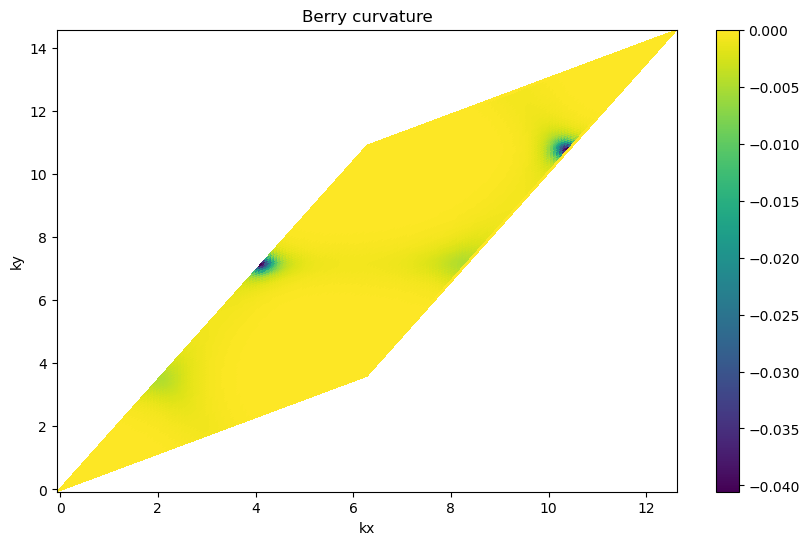

Onsite energy = 0.2
t_A = -0.03849001794597505j
Chern number = -0.9999999999999994


In [12]:
wynik = 0
iloczyn = 0
    
#onsite energy
Onsite = 0.2
#Hopping energies
t_AA = 2j*Onsite/(3*np.sqrt(3))
t_BB = 2j*Onsite/(3*np.sqrt(3))
t_AB = 1
t_BA = 1
#Berry curvature values table for drawing 
berry_values = np.zeros((N2,N2))

for i in range (N2-1):
    for j in range (N2-1):
        hamiltonian = Hamiltonian(Onsite, t_AB, t_BA, t_AA, t_BB, deltas_AB, deltas_BA, deltas_AA, deltas_BB)
        ene1, v1 = hamiltonian.problem_wlasny(grid_points[i][j][0], grid_points[i][j][1])
        ene2, v2 = hamiltonian.problem_wlasny(grid_points[i+1][j][0], grid_points[i+1][j][1])
        ene3, v3 = hamiltonian.problem_wlasny(grid_points[i+1][j+1][0], grid_points[i+1][j+1][1])
        ene4, v4 = hamiltonian.problem_wlasny(grid_points[i][j+1][0], grid_points[i][j+1][1])
            
        iloczyn = (v1[0][1].conjugate()*v2[0][1] + v1[1][1].conjugate()*v2[1][1]) * (v2[0][1].conjugate()*v3[0][1] + v2[1][1].conjugate()*v3[1][1])  * (v3[0][1].conjugate()*v4[0][1] + v3[1][1].conjugate()*v4[1][1]) * (v4[0][1].conjugate()*v1[0][1] + v4[1][1].conjugate()*v1[1][1]) #iloczyn skalarny
        wynik += np.angle(iloczyn) 
        berry_values[i][j]=np.angle(iloczyn)
#Chern number
chern = wynik/(2*np.pi)
#Drawing berry curvature
plt.figure(figsize=(10, 6))
plt.pcolor(kx_values, ky_values, berry_values) 
plt.title("Berry curvature")
plt.colorbar() 
plt.xlabel("kx")
plt.ylabel("ky")
#plt.savefig('Berry_3.jpg', dpi = 300, bbox_inches='tight')
plt.show()   
print(f"Onsite energy = {Onsite}")
print(f"t_A = {t_aa}")
print(f"Chern number = {chern}")

In cells below, the Chern number is calculated again, but for different values of the parameter $t_A = t_B$. The results are saved to an array "dane_chern".

In [13]:
# table_t_aa = []
# table_chern = []
# for i in range(-40,41):
#     wynik = 0
#     iloczyn = 0
#     print(i)
#     #onsite energy
#     Onsite = 0.2
#     #Hopping energies
#     t_AA = 0.05j*i*Onsite/(3*np.sqrt(3))
#     t_BB = 0.05j*i*Onsite/(3*np.sqrt(3))
#     t_aa_2 = 0.05*i*Onsite/(3*np.sqrt(3))
#     t_AB = 1
#     t_BA = 1

#     #potrzebne do rysowania krzywizny berry'ego
#     berry_values = np.zeros((N2,N2), dtype = complex)

#     for i in range (N2-1):
#         for j in range (N2-1):
#             hamiltonian = Hamiltonian(Onsite, t_AB, t_BA, t_AA, t_BB, deltas_AB, deltas_BA, deltas_AA, deltas_BB)
#             ene1, v1 = hamiltonian.problem_wlasny(grid_points[i][j][0], grid_points[i][j][1])
#             ene2, v2 = hamiltonian.problem_wlasny(grid_points[i+1][j][0], grid_points[i+1][j][1])
#             ene3, v3 = hamiltonian.problem_wlasny(grid_points[i+1][j+1][0], grid_points[i+1][j+1][1])
#             ene4, v4 = hamiltonian.problem_wlasny(grid_points[i][j+1][0], grid_points[i][j+1][1])

#             iloczyn = (v1[0][1].conjugate()*v2[0][1] + v1[1][1].conjugate()*v2[1][1]) * (v2[0][1].conjugate()*v3[0][1] + v2[1][1].conjugate()*v3[1][1])  * (v3[0][1].conjugate()*v4[0][1] + v3[1][1].conjugate()*v4[1][1]) * (v4[0][1].conjugate()*v1[0][1] + v4[1][1].conjugate()*v1[1][1]) #iloczyn skalarny
#             berry_values[i][j]=iloczyn
#             wynik += np.angle(iloczyn) 
#     #Liczba Cherna
#     chern = wynik/(2*np.pi)
#     table_t_aa.append(t_aa_2)
#     table_chern.append(chern)

In [14]:
# with open("dane_chern.txt", "w") as plik:
#     for x, y in zip(table_t_aa, table_chern):
#         plik.write(f"{x}\t{y}\n")

Now, we can draw the dependence of Chern number on the hopping apmlitude $t_A = t_B$, using data stored in "dane_chern"

<function matplotlib.pyplot.show(close=None, block=None)>

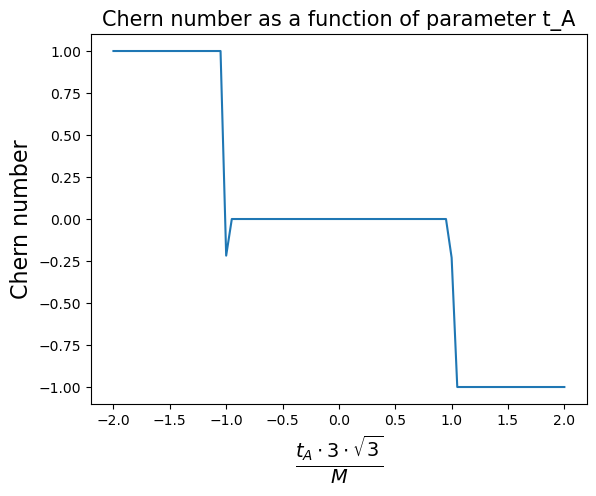

In [15]:
with open("dane_chern.txt", "r") as plik:
    kolumna1 = []
    kolumna2 = []
    t_aax = []
    for linia in plik:
        x, y = map(float, linia.split())  
        kolumna1.append(x*3*np.sqrt(3)/Onsite) #values of t_aa
        t_aax.append(x) #Values of t_aa
        kolumna2.append(y) 
        
#plt.figure(figsize=(10, 6))
plt.plot(kolumna1, kolumna2)
plt.xlabel(r"$\frac{t_{A} \cdot 3 \cdot \sqrt{3}}{M}$", fontsize = 20)
plt.ylabel("Chern number", fontsize = 16)
plt.savefig('Chern.jpg', dpi = 300, bbox_inches='tight')
plt.title("Chern number as a function of parameter t_A", fontsize = 15)
plt.show


In the cells below, we will calculate the band structure again but this time with the help of the Kwant package. We create a system with certain height and width, we define primitive translation vectors and hoppings. Kwant creates the Hamiltonian and solves the eigen problem automatically. 
We are also plotting the propability density and the current. We take into account two different lattice boundaries: zigzag and armchair.

In [16]:
#zigzag
def plot_wf3(p=0):
    sys_gr1 = kwant.Builder()

    graphene_lat = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                     [[0, 0], [0, 1/np.sqrt(3)]], norbs=1)  # Coordinates of the sites

    lat_A, lat_B = graphene_lat.sublattices

    Lmin = -2
    Lmax = 2
    Wmin = -10
    Wmax = 10

    Onsite = 0.2
    t_ab = 1
    t_ba = 1
    #t_aa = 0.1j*p*Onsite/(3*np.sqrt(3))
    #t_bb = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_aa = 1j*t_aax[p] #We go sequentially through the t_aa values in the file dane_chern
    t_bb = 1j*t_aax[p]
    t_aa_real = t_aax[p] 
    t_bb_real = t_aax[p]


    def ribbon(pos):
        x, y = pos
        if Lmin<=x<=Lmax and Wmin<=y<=Wmax:
            return True
        else:
            return False


    sys_gr1[lat_A.shape(ribbon, (0,0))] = Onsite
    sys_gr1[lat_B.shape(ribbon, (0,0))] = -Onsite

    sys_gr1[graphene_lat.neighbors()] = t_ab

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = t_aa  
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = t_aa
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = t_aa

    sys_gr1[kwant.builder.HoppingKind((1, 0), lat_B, lat_B)] = t_bb  
    sys_gr1[kwant.builder.HoppingKind((0, -1), lat_B, lat_B)] = t_bb
    sys_gr1[kwant.builder.HoppingKind((-1, 1), lat_B, lat_B)] = t_bb


    def lead0_shape(pos):
        x, y = pos
        return (Wmin <= y <= Wmax)

    sym = kwant.TranslationalSymmetry([-1, 0])
    sym.add_site_family(graphene_lat.sublattices[0], other_vectors=[(-1, 2)])
    sym.add_site_family(graphene_lat.sublattices[1], other_vectors=[(-1, 2)])

    # creating the leads
    lead = kwant.Builder(sym) 
    lead[lat_A.shape(lead0_shape, (0, 0))] = Onsite
    lead[lat_B.shape(lead0_shape, (0, 0))] = -Onsite

    #lead[(graphene_lat(Lmin, y) for y in range(W))] =0      # no disorder in lead!
    lead[graphene_lat.neighbors()] = t_ab


    lead[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = t_aa
    lead[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = t_aa
    lead[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = t_aa

    lead[kwant.builder.HoppingKind((1, 0), lat_B, lat_B)] = t_bb  
    lead[kwant.builder.HoppingKind((0, -1), lat_B, lat_B)] = t_bb
    lead[kwant.builder.HoppingKind((-1, 1), lat_B, lat_B)] = t_bb

    # attaching the leads
    sys_gr1.attach_lead(lead)
    sys_gr1.attach_lead(lead.reversed())

    sysf_gr1 = sys_gr1.finalized()
    
    kwant.plotter.bands(sysf_gr1.leads[0], show=True,  fig_size = (8,6));
    print(f"Liczba Cherna = {kolumna2[p]}")
    print(f"t_aa = {t_aa_real}")
    latex = r"\frac{{t_{{aa}} \cdot 3 \cdot \sqrt{{3}}}}{{M}} = {}$".format(kolumna1[p])
    display(Math(latex))
    
    wfs = kwant.wave_function(sysf_gr1, energy=0.000001)
    scattering_wf = wfs(0)  # all scattering wave functions from lead 0
    
    print("N =", np.shape(scattering_wf));
    
    kwant.plotter.map(sysf_gr1, np.sum(abs(scattering_wf)**2,axis=0));
    
    J = kwant.operator.Current(sysf_gr1)
    current = sum(J(p) for p in scattering_wf)
    kwant.plotter.current(sysf_gr1, current);
    
    kwant.plot(sys_gr1, fig_size = (14,14),)
    

interact(plot_wf3, p=(0,80))

interactive(children=(IntSlider(value=0, description='p', max=80), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf3(p=0)>

In [17]:
#armchair
def plot_wf3(p=0):
    sys_gr1 = kwant.Builder()

    graphene_lat = kwant.lattice.general([[np.sqrt(3)/2, -1/2], [np.sqrt(3)/2, 1/2]],  # lattice vectors
                                     [[0,0], [1/(2*np.sqrt(3)), 1/2]], norbs=1)  # Coordinates of the sites

    lat_A, lat_B = graphene_lat.sublattices

    Lmin = -2
    Lmax = 2
    Wmin = -10
    Wmax = 10

    Onsite = 0.2
    t_ab = 1
    t_ba = 1
    #t_aa = 0.1j*p*Onsite/(3*np.sqrt(3))
    #t_bb = 0.1j*p*Onsite/(3*np.sqrt(3))
    t_aa = 1j*t_aax[p] #We go sequentially through the t_aa values in the file dane_chern
    t_bb = 1j*t_aax[p]
    t_aa_real = t_aax[p] 
    t_bb_real = t_aax[p]

    def ribbon(pos):
        x, y = pos
        if Lmin<=x<=Lmax and Wmin<=y<=Wmax:
            return True
        else:
            return False

    sys_gr1[lat_A.shape(ribbon, (0,0))] = Onsite
    sys_gr1[lat_B.shape(ribbon, (0,0))] = -Onsite

    sys_gr1[graphene_lat.neighbors()] = t_ab

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = t_aa  
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = t_aa
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = t_aa

    sys_gr1[kwant.builder.HoppingKind((1, 0), lat_B, lat_B)] = t_bb  
    sys_gr1[kwant.builder.HoppingKind((0, -1), lat_B, lat_B)] = t_bb
    sys_gr1[kwant.builder.HoppingKind((-1, 1), lat_B, lat_B)] = t_bb


    def lead0_shape(pos):
        x, y = pos
        return (Wmin <= y <= Wmax)

    sym = kwant.TranslationalSymmetry([np.sqrt(3), 0])
    sym.add_site_family(graphene_lat.sublattices[0], other_vectors=[(1, -1)])
    sym.add_site_family(graphene_lat.sublattices[1], other_vectors=[(1, -1)])

    # creating the leads
    lead = kwant.Builder(sym) 
    lead[lat_A.shape(lead0_shape, (0, 0))] = Onsite
    lead[lat_B.shape(lead0_shape, (0, 0))] = -Onsite

    #lead[(graphene_lat(Lmin, y) for y in range(W))] =0      # no disorder in lead!
    lead[graphene_lat.neighbors()] = t_ab


    lead[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = t_aa
    lead[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = t_aa
    lead[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = t_aa

    lead[kwant.builder.HoppingKind((1, 0), lat_B, lat_B)] = t_bb  
    lead[kwant.builder.HoppingKind((0, -1), lat_B, lat_B)] = t_bb
    lead[kwant.builder.HoppingKind((-1, 1), lat_B, lat_B)] = t_bb

    # attaching the leads
    sys_gr1.attach_lead(lead)
    sys_gr1.attach_lead(lead.reversed())

    sysf_gr1 = sys_gr1.finalized()

    kwant.plotter.bands(sysf_gr1.leads[0], show=True,  fig_size = (8,6));
    print(f"Liczba Cherna = {kolumna2[p]}")
    print(f"t_aa = {t_aa_real}")
    latex = r"\frac{{t_{{aa}} \cdot 3 \cdot \sqrt{{3}}}}{{M}} = {}$".format(kolumna1[p])
    display(Math(latex))
    
    wfs = kwant.wave_function(sysf_gr1, energy=0.01)
    scattering_wf = wfs(0)  # all scattering wave functions from lead 0
    
    print("N =", np.shape(scattering_wf));
    
    kwant.plotter.map(sysf_gr1, np.sum(abs(scattering_wf)**2,axis=0));
    
    J = kwant.operator.Current(sysf_gr1)
    current = sum(J(p) for p in scattering_wf)
    kwant.plotter.current(sysf_gr1, current);
    
    kwant.plot(sys_gr1, fig_size = (14,14),)
interact(plot_wf3, p=(0,80))

interactive(children=(IntSlider(value=0, description='p', max=80), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf3(p=0)>

# Acknowledgements

This research was funded by the National Science Centre Poland (NCN) according to decision 2021/42/E/ST3/00128